In [68]:
import pickle
import os
import networkx as nx
import walker as w
from tqdm import tqdm
import numpy as np

In [2]:
with open('../../data/graphs/3000_similar_noUnknown_noFutureThr2_noIsolates.pkl', 'rb') as f:
    G = pickle.load(f)

In [3]:
# with open('../../data/batch/B_random_10.pkl', 'rb') as f:
#     B_random = pickle.load(f)
with open('../../data/batch/B_recent_10.pkl', 'rb') as f:
    B_recent = pickle.load(f)

In [252]:
nodes = list(G.nodes())

In [4]:
G = G.reverse(copy=False)
nodes = list(G.nodes())

In [27]:
def ids_to_indices(file_ids, nodes):
    index_map = {node: i for i, node in enumerate(nodes)}
    index_map_keys = set(index_map.keys())
    
    indices = []
    for file, ids in file_ids.items():
        for id in ids:
            if id in index_map_keys:
                indices.append(index_map[id])
    return indices


In [28]:
B_recent_idx = ids_to_indices(B_recent, nodes)
# B_random_idx = ids_to_indices(B_random)

In [76]:
walks = w.random_walks(G, n_walks=50, walk_len=5, start_nodes=B_recent_idx)

Random walks - T=94.34s


In [77]:
walks

array([[ 146871,  146871,  146871,  146871,  146871],
       [ 117538,  117538,  117538,  117538,  117538],
       [ 453162,  453162,  453162,  453162,  453162],
       ...,
       [1725122, 1725122, 1725122, 1725122, 1725122],
       [1971346, 1971346, 1971346, 1971346, 1971346],
       [ 892640,  892640,  892640,  892640,  892640]], dtype=uint32)

In [81]:
#unique_walks = [walk for walk in walks if not np.all(np.isclose(walk, walk[0]))]
unique_walks = walks[~np.all(walks == walks[:,[0]], axis=1)]

In [ ]:
# filter out walks with less than 

In [82]:
len(walks), len(unique_walks)

(11126150, 9268300)

In [97]:
# group walks by first node

from collections import defaultdict
walks_by_start = defaultdict(list)

for row in unique_walks:
    walks_by_start[row[0]].append(row)
    
for key in walks_by_start:
    walks_by_start[key] = np.array(walks_by_start[key])
    

In [98]:
for key, walk_nodes in walks_by_start.items():
    # flatten nodes
    walk_nodes = walk_nodes.flatten()
    ids = set(nodes)
    # remove start node
    ids.remove(key)
    
    walks_by_start[key] = ids

In [99]:
counts = []
for key, walk_nodes in walks_by_start.items():
    counts.append(len(walk_nodes))

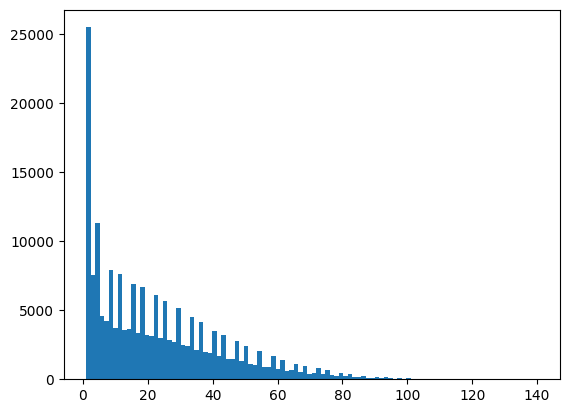

In [100]:
# plot distribution of counts
import matplotlib.pyplot as plt
plt.hist(counts, bins=100)
plt.show()

In [105]:
# filter out nodes with less than 10 neighbors
walks_by_start = {key: nodes for key, nodes in walks_by_start.items() if len(nodes) >= 10}

In [106]:
counts = []
for key, walk_nodes in walks_by_start.items():
    counts.append(len(walk_nodes))

In [107]:
len(counts), np.average(counts), np.median(counts), np.min(counts), np.max(counts)

(124282, 32.80029288231602, 29.0, 10, 140)

In [108]:
target_nodes = walks_by_start.keys()

In [124]:
# errors = []
# for node in (pbar := tqdm(target_nodes)):
#     # check if the target node appears in any of the walks
#     for key, walk in walks_by_start.items():
#         if node == key:
#             continue
#         if node in walk:
#             errors.append((node, key))
#             pbar.set_description(f'Found errors: {len(errors)}')
        

In [143]:
def merge_khops(ids, walks_by_start):
    merged = []
    # deep copy ids
    ids = ids.copy()
    
    errs = 0
    # randomly pick two ids to merge
    for _ in (pbar := tqdm(range(len(ids) // 2))):
        idx1, idx2 = np.random.choice(len(ids), 2, replace=False)
        id1, id2 = ids[idx1], ids[idx2]
        
        khop1 = walks_by_start[id1]
        khop2 = walks_by_start[id2]
        
        overlap = False
        # check if one id is in the other's khop
        for i, k in ([id1, khop2], [id2, khop1]):
            if i in k:
                # dont merge
                overlap = True
                continue
        if overlap:
            errs += 1
            pbar.set_description(f'Found errors: {errs}')
            continue
            
        # merge
        merged.append((id1, id2))
        
        # remove merged ids
        ids.remove(id1)
        ids.remove(id2)
    
    return merged, ids

In [145]:
merged, ids = merge_khops(list(walks_by_start.keys()), walks_by_start)

Found errors: 5: 100%|██████████| 62141/62141 [02:34<00:00, 401.01it/s] 


In [147]:
merged2, ids2 = merge_khops(ids, walks_by_start)
len(merged2), len(ids2)

100%|██████████| 5/5 [00:00<?, ?it/s]


(5, 0)

In [150]:
# append merged ids to walks_by_start
merged = merged + merged2

In [151]:
def merge_merged(walks_by_start, merged):
    merged = merged.copy() # array of tuples
    merged_merged = []
    errs = 0
    for _ in (pbar := tqdm(range(len(merged) // 2))):
        idx1, idx2 = np.random.choice(len(merged), 2, replace=False)
        ids1, ids2 = merged[idx1], merged[idx2]
        
        err = False
        for id1 in ids1:
            khop1 = walks_by_start[id1]
            for id2 in ids2:
                khop2 = walks_by_start[id2]
                
                if id1 in khop2 or id2 in khop1:
                    errs += 1
                    pbar.set_description(f'Found errors: {errs}')
                    err = True
                    break
            if err:
                break
            
        if err:
            continue
        
        # merge
        ids = ids1 + ids2
        merged_merged.append(ids)
        
        # remove merged idx from merged
        merged.remove(ids1)
        merged.remove(ids2)
        
    return merged_merged, merged
        

In [152]:
merged_merged, not_merged = merge_merged(walks_by_start, merged)

Found errors: 20: 100%|██████████| 31070/31070 [01:45<00:00, 295.59it/s] 


In [153]:
len(merged_merged), len(not_merged)

(31050, 41)

In [154]:
merged_merged2, not_merged2 = merge_merged(walks_by_start, not_merged)

100%|██████████| 20/20 [00:00<00:00, 20882.77it/s]


In [155]:
merged_merged = merged_merged + merged_merged2

In [159]:
m3, not_merged3 = merge_merged(walks_by_start, merged_merged)

Found errors: 34: 100%|██████████| 15535/15535 [00:17<00:00, 867.91it/s] 


In [161]:
m3_2, not_merged3_2 = merge_merged(walks_by_start, not_merged3)

100%|██████████| 34/34 [00:00<00:00, 11451.56it/s]


In [163]:
m3 = m3 + m3_2

In [165]:
m4, not_merged4 = merge_merged(walks_by_start, m3)

Found errors: 89: 100%|██████████| 7767/7767 [00:04<00:00, 1573.61it/s]


In [167]:
m4_2, not_merged4_2 = merge_merged(walks_by_start, not_merged4)

100%|██████████| 89/89 [00:00<00:00, 17786.02it/s]


In [168]:
m4 = m4 + m4_2

In [178]:
def idx_to_id(idx):
    # idx is a single index or an array of indices
    if isinstance(idx, int):
        return nodes[idx]
    else:
        return [nodes[i] for i in idx]

def merge_khops(merged_ids, walks_by_start):
    merged = []
    for ids in merged_ids:
        khop_ids = set()
        for id in ids:
            khop = list(walks_by_start[id])
            khop_ids.update(idx_to_id(khop))
        
        merged.append((idx_to_id(ids), khop_ids))
        
    return merged

In [179]:
merged_khops = merge_khops(m4, walks_by_start)

In [189]:
counts = []
for khop_ids, khop in merged_khops:
    counts.append(len(set(khop)))

In [191]:
# average counts (by column)
np.average(counts), np.median(counts), np.min(counts), np.max(counts)

(521.8654564181795, 519.0, 295, 877)

In [187]:
# save merged khops
with open('../../data/batch/B_recent_10_merged_khops.pkl', 'wb') as f:
    pickle.dump(merged_khops, f)

In [245]:
m5, not_merged5 = merge_merged(walks_by_start, m4)

Found errors: 172: 100%|██████████| 3883/3883 [00:01<00:00, 2131.96it/s]


In [246]:
m5_2, not_merged5_2 = merge_merged(walks_by_start, not_merged5)

Found errors: 8: 100%|██████████| 172/172 [00:00<00:00, 4082.44it/s]


In [247]:
m5_3, not_merged5_3 = merge_merged(walks_by_start, not_merged5_2)

Found errors: 1: 100%|██████████| 8/8 [00:00<00:00, 4001.72it/s]


In [248]:
m5 = m5 + m5_2 + m5_3

In [250]:
m5 = m5 + not_merged5_3

In [254]:
len(m5)

3885

In [253]:
merge_khops5 = merge_khops(m5, walks_by_start)

counts = []
for khop_ids, khop in merge_khops5:
    counts.append(len(set(khop)))

# average counts (by column)
np.average(counts), np.median(counts), np.min(counts), np.max(counts)

(1037.344658944659, 1033.0, 410, 1461)

In [255]:
# save merged khops
with open('../../data/batch/B_recent_10_merged_khops_1k.pkl', 'wb') as f:
    pickle.dump(merge_khops5, f)

In [257]:
m6, not_merged6 = merge_merged(walks_by_start, m5)

Found errors: 323: 100%|██████████| 1942/1942 [00:01<00:00, 1235.58it/s]


In [258]:
m6_2, not_merged6_2 = merge_merged(walks_by_start, not_merged6)

Found errors: 65: 100%|██████████| 323/323 [00:00<00:00, 1513.04it/s]


In [259]:
m6_3, not_merged6_3 = merge_merged(walks_by_start, not_merged6_2)

Found errors: 13: 100%|██████████| 65/65 [00:00<00:00, 1114.67it/s]


In [260]:
m6 = m6 + m6_2 + m6_3

In [261]:
merged_khops6 = merge_khops(m6, walks_by_start)

In [262]:
counts = []
for khop_ids, khop in merged_khops6:
    counts.append(len(set(khop)))
    
# average counts (by column)
np.average(counts), np.median(counts), np.min(counts), np.max(counts)

(2050.810264385692, 2048.0, 1366, 2529)

In [264]:
len(counts)

1929

In [263]:
# save merged khops
with open('../../data/batch/B_recent_10_merged_khops_2k.pkl', 'wb') as f:
    pickle.dump(merge_khops5, f)

In [194]:
ex_ids = merged_khops[0]
ex_targets, ex_khop = ex_ids

In [195]:
G = G.reverse(copy=False)

In [199]:
ex_subgraph = G.subgraph(list(ex_khop) + ex_targets)

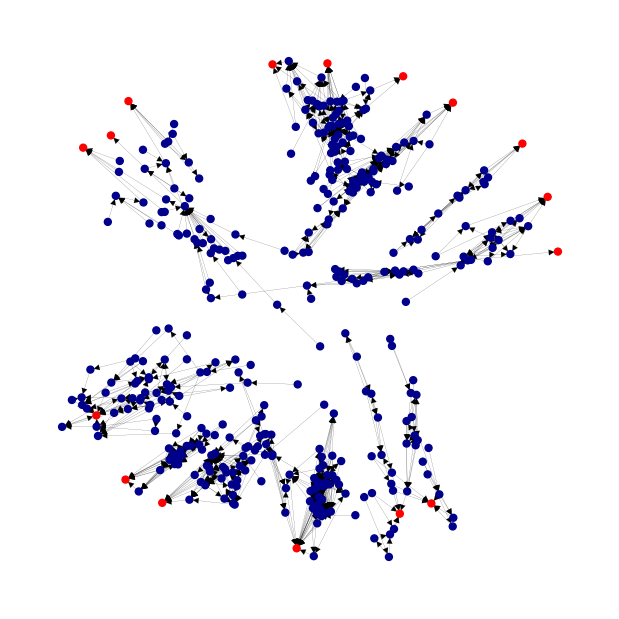

In [214]:
# draw subgraph, drawing the targets in red
import matplotlib.pyplot as plt
plt.figure(figsize=(6,6))
node_color = ['red' if node in ex_targets else 'darkblue' for node in ex_subgraph.nodes()]

# Using spring_layout with a higher k value to increase space between nodes
pos = nx.spring_layout(ex_subgraph, k=0.1, iterations=45)  # You can adjust k and iterations as needed

nx.draw(ex_subgraph, pos, node_color=node_color, with_labels=False, node_size=25, width=0.1)
plt.show()

In [220]:
def khops_to_subgraph(merged_khops):
    subgraphs = []
    for targets, khop in tqdm(merged_khops):
        subgraph = G.subgraph(list(khop) + targets)
        
        # add node_type
        for node in subgraph.nodes():
            if node in targets:
                subgraph.nodes[node]['node_type'] = 'event_target'
            else:
                subgraph.nodes[node]['node_type'] = 'event'
        
        subgraphs.append(subgraph)
    return subgraphs

In [221]:
subgraphs = khops_to_subgraph(merged_khops)

100%|██████████| 7767/7767 [00:10<00:00, 755.79it/s]
